# Reset Call/Put Pricing Verification

In [6]:
import numpy as np
import scipy as sp
import pandas as pd
import re
from scipy.stats import norm,multivariate_normal
import matplotlib.pyplot as plt
import os
import requests
import websocket
import json
from websocket import create_connection
import time
import pandas as pd
import numpy as np
from scipy.stats import norm
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
pd.set_option('display.max_colwidth',300)
from IPython.display import clear_output
import random
from scipy.optimize import fsolve

### Check Reset Call

Test cases involves:
1. Call & Put
2. Different duration
3. Different instrument (different volatility index)




In [7]:
def bivariate(x,y,rho):
    return multivariate_normal.cdf([x,y],cov=[[1,rho],[rho,1]])

def reset_mc(T, vol, samples, phi):
    reset_spot = np.exp(-vol ** 2 / 2 * (T / 2) + vol * np.sqrt(T / 2) * np.random.normal(0, 1, samples))
    end_spot = reset_spot * np.exp(-vol ** 2 / 2 * (T / 2) + vol * np.sqrt(T / 2) * np.random.normal(0, 1, samples))
    return (np.sum((end_spot > 1) | (end_spot > reset_spot)) / samples) if phi == 1 else (np.sum((end_spot < 1) | (end_spot < reset_spot)) / samples)

def reset (T,vol,phi):
    t=T/2
    sigma = vol
    d2t = - sigma**2/2 * t / ( sigma * np.sqrt(t) )
    d2Tt = - sigma**2/2 * (T-t) / ( sigma * np.sqrt(T-t) )
    d2T = - sigma**2/2 * T / ( sigma * np.sqrt(T) )
    rho = np.sqrt(t/T)
    price = norm.cdf(phi * -d2t) * norm.cdf(phi * d2Tt) + bivariate(phi * d2T, phi * d2t, rho)
    return price

def reset_neg (T,vol,phi):
    t=T/2
    sigma = vol
    d2t = - sigma**2/2 * t / ( sigma * np.sqrt(t) )
    d2Tt = - sigma**2/2 * (T-t) / ( sigma * np.sqrt(T-t) )
    d2T = - sigma**2/2 * T / ( sigma * np.sqrt(T) )
    rho = np.sqrt(t/T)
    price = norm.cdf(phi * -d2t) * norm.cdf(phi * d2Tt) + bivariate(-phi * d2T, -phi * d2t, rho)
    return price

def reset_1m (T,vol,phi):
    t=T/2
    sigma = vol
    d2t = - sigma**2/2 * t / ( sigma * np.sqrt(t) )
    d2Tt = - sigma**2/2 * (T-t) / ( sigma * np.sqrt(T-t) )
    d2T = - sigma**2/2 * T / ( sigma * np.sqrt(T) )
    rho = np.sqrt(t/T)
    price = norm.cdf(phi * -d2t) * norm.cdf(phi * d2Tt) + (1-bivariate(phi * d2T, phi * d2t, rho))
    return price

def reset_1m_neg (T,vol,phi):
    t=T/2
    sigma = vol
    d2t = - sigma**2/2 * t / ( sigma * np.sqrt(t) )
    d2Tt = - sigma**2/2 * (T-t) / ( sigma * np.sqrt(T-t) )
    d2T = - sigma**2/2 * T / ( sigma * np.sqrt(T) )
    rho = np.sqrt(t/T)
    price = norm.cdf(phi * -d2t) * norm.cdf(phi * d2Tt) + (1-bivariate(-phi * d2T, -phi * d2t, rho))
    return price

In [8]:
def reset_org(T,v,phi):
    S=1
    K=1
    m=0
    r_q=0
    t=T/2
    if T<=t:
        b2 = (np.log(S/K)-(v**2*(T))/2)/v/np.sqrt(T) #This is not correct when mu is non-zero
        return norm.cdf(b2)*np.exp(-r_q*T)
    a2 = (m-r_q-(v**2/2))*(T-t)/v/np.sqrt(T-t)
    b2 = (m-r_q-(v**2/2))*(T)/v/np.sqrt(T)
    c2 = (m-r_q-(v**2/2))*(t)/v/np.sqrt(t)
    rho = np.sqrt((T-t)/T)
    price = norm.cdf(phi * (c2+v*np.sqrt(t)))*norm.cdf(phi * -a2)
    return price*np.exp(-r_q*T)+bivariate(phi*(a2+v*np.sqrt(t)),phi*(b2+v*np.sqrt(t)),rho)

In [17]:
prices = pd.DataFrame(columns=['Option','Duration','Volatility','MC_price',\
                                  'Formula','Neg_Biv',"1_Minus",'1_minus_neg','Formula_Org'])

In [19]:
for i in range (5000):
    T = np.random.uniform()
    vol = np.random.uniform()
    samples = 2000000
    phi = 1 if np.random.uniform()>0.5 else -1
    prices.loc[len(prices)]=(('Reset Call' if phi ==1 else 'Reset Put'),T,vol,reset_mc(T,vol,samples,phi),reset(T,vol,phi),\
                                   reset_neg(T,vol,phi),reset_1m(T,vol,phi),reset_1m_neg(T,vol,phi),reset_org(T,vol,phi))


In [100]:
prices['MC_samples'] = samples
prices['d_f'] =abs( prices.Formula/prices.MC_price - 1) * 100
prices['d_NB'] =abs( prices.Neg_Biv/prices.MC_price - 1) * 100
prices['d_1M'] =abs( prices['1_Minus']/prices.MC_price - 1) * 100
prices['d_1MN'] =abs( prices['1_minus_neg']/prices.MC_price - 1) * 100
prices['d_Org'] =abs( prices.Formula_Org/prices.MC_price - 1) * 100
print('Formula - MC:',prices.d_f.mean()),print('Neg_Biv - MC:',prices.d_NB.mean()),print('1_Minus - MC:',prices.d_1M.mean()),print('1_minus_neg - MC:',prices.d_1MN.mean()),print('Formula_Org - MC:',prices.d_Org.mean())

Formula - MC: 0.04458603974703887
Neg_Biv - MC: 18.458373421220728
1_Minus - MC: 42.88985474969883
1_minus_neg - MC: 40.060669864174045
Formula_Org - MC: 23.139374489313738


(None, None, None, None, None)

In [43]:
prices.sort_values("d_f",ascending=False).reset_index(drop=True).head(10)

,Option,Duration,Volatility,MC_price,Formula,Neg_Biv,1_Minus,1_minus_neg,Formula_Org,MC_samples,d_f,d_NB,d_1M,d_1MN,d_Org
0,Reset Call,0.666437,0.169070,0.602655,0.601326,0.648295,0.897917,0.850947,0.660329,2000000,0.220530,7.573214,48.993481,41.199737,9.570001
1,Reset Call,0.233956,0.593528,0.574271,0.575437,0.672929,0.921295,0.823803,0.699378,2000000,0.203065,17.179666,60.428583,43.451982,21.785413
2,Reset Call,0.350911,0.072163,0.616459,0.617704,0.632260,0.882223,0.867668,0.635852,2000000,0.202050,2.563204,43.111538,40.750384,3.145933
3,Reset Call,0.812642,0.628804,0.527413,0.526349,0.717343,0.961036,0.770042,0.774801,2000000,0.201775,36.011522,82.216718,46.003421,46.905768
4,Reset Call,0.737747,0.211873,0.592580,0.593721,0.655621,0.904963,0.843063,0.671753,2000000,0.192488,10.638464,52.715829,42.269853,13.360770
5,Reset Call,0.510141,0.962823,0.506054,0.505103,0.735671,0.976446,0.745878,0.808082,2000000,0.187843,45.374031,92.952848,47.390974,59.682962
6,Reset Call,0.760943,0.893439,0.489922,0.489025,0.749191,0.987408,0.727241,0.833553,2000000,0.182985,52.920709,101.544101,48.440407,70.140084
7,Reset Call,0.705110,0.831996,0.502266,0.503181,0.737303,0.977788,0.743666,0.811114,2000000,0.182329,46.795508,94.675457,48.062278,61.491033
8,Reset Call,0.206442,0.685581,0.570142,0.571172,0.676905,0.924982,0.819250,0.705856,2000000,0.180652,18.725567,62.237039,43.692124,23.803457
9,Reset Call,0.535149,0.615667,0.547798,0.546828,0.699171,0.945169,0.792826,0.743100,2000000,0.177137,27.632954,72.539729,44.729639,35.652114


In [23]:
prices.sort_values("d_NB",ascending=False).reset_index(drop=True).head(10)

,Option,Duration,Volatility,MC_price,Formula,Neg_Biv,1_Minus,1_minus_neg,Formula_Org,MC_samples,d_f,d_NB,d_1M,d_1MN,d_Org
0,Reset Call,0.974129,0.976057,0.456726,0.456978,0.775255,1.007487,0.689210,0.885115,2000000,0.055191,69.741926,120.589149,50.902414,93.795778
1,Reset Call,0.954446,0.978844,0.457987,0.458200,0.774282,1.006764,0.690682,0.883128,2000000,0.046393,69.061816,119.823454,50.808031,92.827867
2,Reset Call,0.983362,0.960758,0.458369,0.458816,0.773791,1.006398,0.691423,0.882127,2000000,0.097527,68.814020,119.560726,50.844232,92.449022
3,Reset Call,0.972050,0.960359,0.459766,0.459837,0.772977,1.005791,0.692650,0.880470,2000000,0.015360,68.124009,118.761431,50.652782,91.503834
4,Reset Call,0.940820,0.966926,0.461034,0.461391,0.771735,1.004861,0.694517,0.877948,2000000,0.077403,67.392204,117.958068,50.643267,90.430233
5,Reset Call,0.904987,0.989838,0.461418,0.460738,0.772257,1.005252,0.693734,0.879006,2000000,0.147270,67.365958,117.861415,50.348186,90.501051
6,Reset Call,0.961032,0.955336,0.461521,0.461624,0.771549,1.004721,0.694796,0.877571,2000000,0.022230,67.175219,117.697803,50.544815,90.147529
7,Reset Call,0.908059,0.982324,0.461531,0.461703,0.771485,1.004673,0.694892,0.877441,2000000,0.037452,67.157947,117.682943,50.562447,90.115602
8,Reset Call,0.883851,0.996391,0.461848,0.461588,0.771577,1.004742,0.694753,0.877628,2000000,0.056145,67.063170,117.548507,50.429192,90.025533
9,Reset Call,0.902478,0.983826,0.462066,0.461956,0.771283,1.004522,0.695194,0.877033,2000000,0.023905,66.920532,117.397860,50.453422,89.806804


In [24]:
prices.sort_values("d_1M",ascending=False).reset_index(drop=True).head(10)

,Option,Duration,Volatility,MC_price,Formula,Neg_Biv,1_Minus,1_minus_neg,Formula_Org,MC_samples,d_f,d_NB,d_1M,d_1MN,d_Org
0,Reset Call,0.974129,0.976057,0.456726,0.456978,0.775255,1.007487,0.689210,0.885115,2000000,0.055191,69.741926,120.589149,50.902414,93.795778
1,Reset Call,0.954446,0.978844,0.457987,0.458200,0.774282,1.006764,0.690682,0.883128,2000000,0.046393,69.061816,119.823454,50.808031,92.827867
2,Reset Call,0.983362,0.960758,0.458369,0.458816,0.773791,1.006398,0.691423,0.882127,2000000,0.097527,68.814020,119.560726,50.844232,92.449022
3,Reset Call,0.972050,0.960359,0.459766,0.459837,0.772977,1.005791,0.692650,0.880470,2000000,0.015360,68.124009,118.761431,50.652782,91.503834
4,Reset Call,0.940820,0.966926,0.461034,0.461391,0.771735,1.004861,0.694517,0.877948,2000000,0.077403,67.392204,117.958068,50.643267,90.430233
5,Reset Call,0.904987,0.989838,0.461418,0.460738,0.772257,1.005252,0.693734,0.879006,2000000,0.147270,67.365958,117.861415,50.348186,90.501051
6,Reset Call,0.961032,0.955336,0.461521,0.461624,0.771549,1.004721,0.694796,0.877571,2000000,0.022230,67.175219,117.697803,50.544815,90.147529
7,Reset Call,0.908059,0.982324,0.461531,0.461703,0.771485,1.004673,0.694892,0.877441,2000000,0.037452,67.157947,117.682943,50.562447,90.115602
8,Reset Call,0.883851,0.996391,0.461848,0.461588,0.771577,1.004742,0.694753,0.877628,2000000,0.056145,67.063170,117.548507,50.429192,90.025533
9,Reset Call,0.902478,0.983826,0.462066,0.461956,0.771283,1.004522,0.695194,0.877033,2000000,0.023905,66.920532,117.397860,50.453422,89.806804


In [25]:
prices.sort_values("d_1MN",ascending=False).reset_index(drop=True).head(10)

,Option,Duration,Volatility,MC_price,Formula,Neg_Biv,1_Minus,1_minus_neg,Formula_Org,MC_samples,d_f,d_NB,d_1M,d_1MN,d_Org
0,Reset Call,0.974129,0.976057,0.456726,0.456978,0.775255,1.007487,0.689210,0.885115,2000000,0.055191,69.741926,120.589149,50.902414,93.795778
1,Reset Call,0.983362,0.960758,0.458369,0.458816,0.773791,1.006398,0.691423,0.882127,2000000,0.097527,68.814020,119.560726,50.844232,92.449022
2,Reset Call,0.954446,0.978844,0.457987,0.458200,0.774282,1.006764,0.690682,0.883128,2000000,0.046393,69.061816,119.823454,50.808031,92.827867
3,Reset Call,0.972050,0.960359,0.459766,0.459837,0.772977,1.005791,0.692650,0.880470,2000000,0.015360,68.124009,118.761431,50.652782,91.503834
4,Reset Call,0.940820,0.966926,0.461034,0.461391,0.771735,1.004861,0.694517,0.877948,2000000,0.077403,67.392204,117.958068,50.643267,90.430233
5,Reset Call,0.908059,0.982324,0.461531,0.461703,0.771485,1.004673,0.694892,0.877441,2000000,0.037452,67.157947,117.682943,50.562447,90.115602
6,Reset Call,0.961032,0.955336,0.461521,0.461624,0.771549,1.004721,0.694796,0.877571,2000000,0.022230,67.175219,117.697803,50.544815,90.147529
7,Reset Call,0.864783,0.988407,0.464050,0.464640,0.769129,1.002899,0.698410,0.872685,2000000,0.127106,65.742586,116.118490,50.503010,88.058244
8,Reset Call,0.983383,0.940322,0.462338,0.462328,0.770985,1.004297,0.695641,0.876429,2000000,0.002269,66.757630,117.221248,50.461348,89.564377
9,Reset Call,0.914690,0.969579,0.463056,0.463226,0.770265,1.003756,0.696717,0.874974,2000000,0.036904,66.343901,116.767872,50.460875,88.956580


In [26]:
prices.sort_values("d_Org",ascending=False).reset_index(drop=True).head(10)

,Option,Duration,Volatility,MC_price,Formula,Neg_Biv,1_Minus,1_minus_neg,Formula_Org,MC_samples,d_f,d_NB,d_1M,d_1MN,d_Org
0,Reset Call,0.974129,0.976057,0.456726,0.456978,0.775255,1.007487,0.689210,0.885115,2000000,0.055191,69.741926,120.589149,50.902414,93.795778
1,Reset Call,0.954446,0.978844,0.457987,0.458200,0.774282,1.006764,0.690682,0.883128,2000000,0.046393,69.061816,119.823454,50.808031,92.827867
2,Reset Call,0.983362,0.960758,0.458369,0.458816,0.773791,1.006398,0.691423,0.882127,2000000,0.097527,68.814020,119.560726,50.844232,92.449022
3,Reset Call,0.972050,0.960359,0.459766,0.459837,0.772977,1.005791,0.692650,0.880470,2000000,0.015360,68.124009,118.761431,50.652782,91.503834
4,Reset Call,0.904987,0.989838,0.461418,0.460738,0.772257,1.005252,0.693734,0.879006,2000000,0.147270,67.365958,117.861415,50.348186,90.501051
5,Reset Call,0.940820,0.966926,0.461034,0.461391,0.771735,1.004861,0.694517,0.877948,2000000,0.077403,67.392204,117.958068,50.643267,90.430233
6,Reset Call,0.961032,0.955336,0.461521,0.461624,0.771549,1.004721,0.694796,0.877571,2000000,0.022230,67.175219,117.697803,50.544815,90.147529
7,Reset Call,0.908059,0.982324,0.461531,0.461703,0.771485,1.004673,0.694892,0.877441,2000000,0.037452,67.157947,117.682943,50.562447,90.115602
8,Reset Call,0.883851,0.996391,0.461848,0.461588,0.771577,1.004742,0.694753,0.877628,2000000,0.056145,67.063170,117.548507,50.429192,90.025533
9,Reset Call,0.902478,0.983826,0.462066,0.461956,0.771283,1.004522,0.695194,0.877033,2000000,0.023905,66.920532,117.397860,50.453422,89.806804


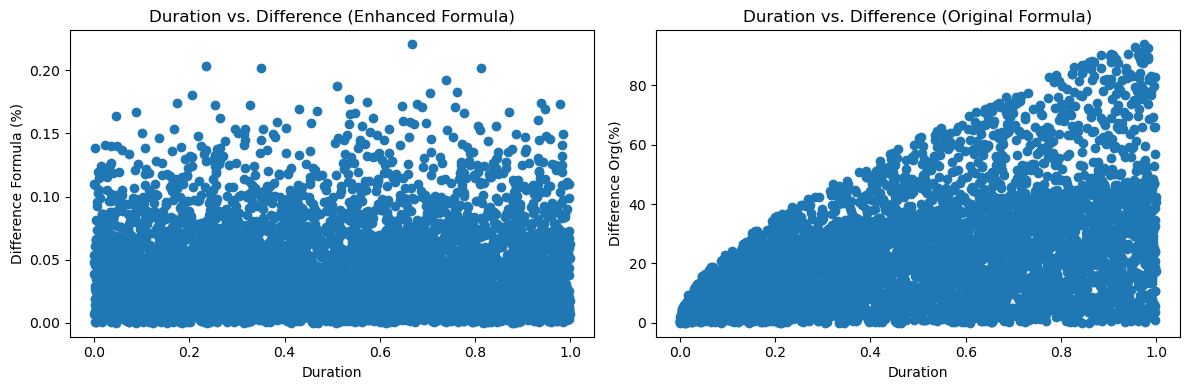

In [101]:
plt.figure(figsize=(12, 4))

# First subplot (left)
plt.subplot(1, 2, 1)
plt.scatter(prices['Duration'], prices['d_f'])
plt.xlabel('Duration')
plt.ylabel('Difference Formula (%)')
plt.title('Duration vs. Difference (Enhanced Formula)')

# Second subplot (right)
plt.subplot(1, 2, 2)
plt.scatter(prices['Duration'], prices['d_Org'])
plt.xlabel('Duration')
plt.ylabel('Difference Org(%)')
plt.title('Duration vs. Difference (Original Formula)')

# Adjust the layout to prevent overlapping labels
plt.tight_layout()

# Display the plots
plt.show()

In [72]:
prices_d = pd.DataFrame(columns=['Option','Duration','Volatility','MC_price',\
                                  'Formula','Neg_Biv',"1_Minus",'1_minus_neg','Formula_Org'])

In [73]:
for i in range (5000):
    T = np.random.randint(5,7201)/365/86400
    vol = random.choice([0.1,0.25,0.5,0.75,1])
    samples = 2000000
    phi = a
    prices_d.loc[len(prices_d)]=(('Reset Call' if phi ==1 else 'Reset Put'),T,vol,reset_mc(T,vol,samples,phi),reset(T,vol,phi),\
                                   reset_neg(T,vol,phi),reset_1m(T,vol,phi),reset_1m_neg(T,vol,phi),reset_org(T,vol,phi))


In [74]:
prices_d['MC_samples'] = samples
prices_d['d_f'] =abs( prices_d.Formula/prices_d.MC_price - 1) * 100
prices_d['d_NB'] =abs( prices_d.Neg_Biv/prices_d.MC_price - 1) * 100
prices_d['d_1M'] =abs( prices_d['1_Minus']/prices_d.MC_price - 1) * 100
prices_d['d_1MN'] =abs( prices_d['1_minus_neg']/prices_d.MC_price - 1) * 100
prices_d['d_Org'] =abs( prices_d.Formula_Org/prices_d.MC_price - 1) * 100
print('Formula - MC:',prices_d.d_f.mean()),print('Neg_Biv - MC:',prices_d.d_NB.mean()),print('1_Minus - MC:',prices_d.d_1M.mean()),print('1_minus_neg - MC:',prices_d.d_1MN.mean()),print('Formula_Org - MC:',prices_d.d_Org.mean())

Formula - MC: 0.04349271863528493
Neg_Biv - MC: 0.28956705191691956
1_Minus - MC: 40.000356185043906
1_minus_neg - MC: 39.99982204604648
Formula_Org - MC: 0.35870674061842867


(None, None, None, None, None)

# API testing

In [207]:
master_URL = "wss://qa69.deriv.dev/websockets/v3?app_id=16303&l=EN&brand=deriv"
api_token =  ''
vol_symbols = ['1HZ10V', '1HZ25V', '1HZ50V', '1HZ75V', '1HZ100V', 'R_10', 'R_25', 'R_50', 'R_75', 'R_100' ]

In [160]:
def get_contract (symbol, duration, duration_unit, contract_type,stake): 
    return_json = []
    def on_open(ws):        
        msg = {
            "authorize": api_token,
        }
        ws.send(json.dumps(msg))
    def on_message(ws, message):
        amount = 100        
        message = json.loads(message)  
        print(message)
        if 'authorize' in message:
            msg = {
                "buy": "1",
                "parameters" :
                {
                    "amount": amount,
                    "basis": "stake",
                    "contract_type": contract_type,
                    "currency": "USD",
                    "duration": duration,
                    "duration_unit": duration_unit,
                    "symbol": symbol
                },
                "price": amount
            }
            ws.send(json.dumps(msg))            
        else:
            return_json.append(message)            
            ws.close()                                          
    def on_close(ws, close_status_code, close_msg):
        print()
    ws = websocket.WebSocketApp(master_URL, on_message = on_message, on_open = on_open, on_close=on_close)
    ws.run_forever()   
    return return_json[-1]

In [202]:
def calc_payout (prop, dur, dur_unit):
    phi = 1 if prop['echo_req']['parameters']['contract_type'] == 'RESETCALL' else -1    
    if dur_unit == 't':
        if 'R' in prop['echo_req']['parameters']['symbol']: 
            T = dur*2 / 365 / 86400
            t = ((dur*2/2 ) - (dur*2/2 % 2)) / 365 / 86400
        else:
            T = dur / 365 / 86400
            t = (dur//2)/ 365 / 86400
    elif dur_unit == 'm':
        T = dur / 365 / 24 / 60
        t = T / 2
    elif dur_unit == 'h':
        T = dur / 365 / 24 
        t = T / 2
    sigma = int(re.search(r'\d+', prop['echo_req']['parameters']['symbol'][1:]).group())/100
    d2t = - sigma**2/2 * t / ( sigma * np.sqrt(t) )
    d2Tt = - sigma**2/2 * (T-t) / ( sigma * np.sqrt(T-t) )
    d2T = - sigma**2/2 * T / ( sigma * np.sqrt(T) )
    mark_up = 1.2 / 100
    rho = np.sqrt(t/T)
    price = norm.cdf(phi * -d2t) * norm.cdf(phi * d2Tt) + bivariate(phi * d2T, phi * d2t, rho) + mark_up
    return prop['buy']['buy_price'] / price

def calc_payout_inc (c_type, symbol, dur, dur_unit):
    phi = 1 if c_type == 'RESETCALL' else -1    
    dur *= (2 if 'R' in symbol else 1)
    if dur_unit == 't':
        T = dur / 365 / 86400
        t = (dur//2)/ 365 / 86400
    elif dur_unit == 'm':
        T = dur / 365 / 24 / 60
        t = T / 2
    elif dur_unit == 'h':
        T = dur / 365 / 24 
        t = T / 2
    t += (0 if 'R' in symbol else 0.5) / 365 / 86400
    sigma = int(re.search(r'\d+', symbol[1:]).group())/100
    d2t = - sigma**2/2 * t / ( sigma * np.sqrt(t) )
    d2Tt = - sigma**2/2 * (T-t) / ( sigma * np.sqrt(T-t) )
    d2T = - sigma**2/2 * T / ( sigma * np.sqrt(T) )
    mark_up = 1.2 / 100
    rho = np.sqrt(t/T)
    price = norm.cdf(phi * -d2t) * norm.cdf(phi * d2Tt) + bivariate(phi * d2T, phi * d2t, rho) + mark_up
    return 100 / price

In [209]:
# PPP_df = pd.DataFrame(columns=['asset', 'contract_type', 'spot_time', 'stake', 'duration', 'id', 'api_payout', 'calc_payout'])
while True:
    clear_output(wait=True)
    print(len(PPP_df))    
    if len(PPP_df)>200-1:
        break        
    contract_type = random.choice(["RESETCALL", "RESETPUT"])
    asset = random.choice(vol_symbols)
    duration_unit = random.choice(['t','m','h'])
    if duration_unit == 't':
        min_duration = 5
        max_duration = 10
    elif duration_unit == 'm':
        min_duration = 1
        max_duration = 120
    elif duration_unit == 'h':
        min_duration = 1
        max_duration = 2    
    i = np.random.randint(5)    
    if i<2:        
        duration = max(min_duration,max_duration**i)
    else:
        duration = np.random.randint(min_duration, max_duration)
    proposal = get_contract(asset, duration, duration_unit, contract_type, 0)    
    PPP_df.loc[len(PPP_df)] = [proposal['echo_req']['parameters']['symbol'], proposal['echo_req']['parameters']['contract_type'], \
                               proposal['buy']['start_time'], float(proposal['buy']['buy_price']),
                               str(duration)+duration_unit,proposal['buy']['contract_id'], \
                               float(proposal['buy']['payout']),calc_payout(proposal,duration,duration_unit)]                               
clear_output(wait=True)
PPP_df

,asset,contract_type,spot_time,stake,duration,id,api_payout,calc_payout
0,R_25,RESETPUT,1694573289,100.0,1h,1639,156.87,156.873891
1,1HZ75V,RESETPUT,1694573290,100.0,120m,1659,156.51,156.512116
2,R_50,RESETPUT,1694573291,100.0,87m,1679,156.72,156.716517
3,R_50,RESETPUT,1694573291,100.0,1h,1699,156.76,156.762105
4,R_50,RESETPUT,1694573292,100.0,5t,1719,156.97,161.023782
...,...,...,...,...,...,...,...,...
195,1HZ75V,RESETCALL,1694573897,100.0,120m,5539,157.46,157.463137
196,R_25,RESETPUT,1694573898,100.0,40m,5559,156.89,156.894425
197,1HZ100V,RESETCALL,1694573900,100.0,5t,5579,157.00,161.054982
198,R_10,RESETCALL,1694573901,100.0,120m,5599,157.05,157.049303


In [210]:
print(len(PPP_df), 'Test cases','\nMismatches =',\
      len(PPP_df[(PPP_df.api_payout) - np.round(PPP_df.calc_payout,2) != 0]),\
      '\nMismatches listed below :')
df = PPP_df[(PPP_df.api_payout) - np.round(PPP_df.calc_payout,2) != 0].reset_index(drop=True)
df

200 Test cases 
Mismatches = 27 
Mismatches listed below :


,asset,contract_type,spot_time,stake,duration,id,api_payout,calc_payout
0,R_50,RESETPUT,1694573292,100.0,5t,1719,156.97,161.023782
1,1HZ75V,RESETCALL,1694573320,100.0,7t,2099,157.00,159.864210
2,1HZ10V,RESETCALL,1694573325,100.0,9t,2139,156.99,159.202595
3,R_75,RESETCALL,1694573330,100.0,5t,2219,157.00,161.056091
4,1HZ25V,RESETCALL,1694573340,100.0,5t,2379,156.99,161.041273
5,1HZ25V,RESETCALL,1694573341,100.0,9t,2399,156.99,159.206131
6,R_75,RESETPUT,1694573348,100.0,5t,2479,156.97,161.017322
7,R_25,RESETPUT,1694573352,100.0,5t,2559,156.98,161.030243
8,R_10,RESETCALL,1694573363,100.0,5t,2759,156.99,161.039289
9,1HZ25V,RESETCALL,1694573368,100.0,5t,2839,156.99,161.041273


In [211]:
df['calc_payout_incorrect_reset'] = 0
for i in df.index:
    df.at[i,'calc_payout_incorrect_reset'] = calc_payout_inc (df.at[i,'contract_type'], df.at[i,'asset'], int(df.at[i,'duration'][0]), df.at[i,'duration'][1])
print('Calculating using incorrect reset time.')
print(len(df), 'Test cases','\nMismatches =', len(df[(df.api_payout) - np.round(df.calc_payout_incorrect_reset,2) != 0]),'\nMismatches listed below :')
df[(df.api_payout) - np.round(df.calc_payout_incorrect_reset,2) != 0]

Calculating using incorrect reset time.
27 Test cases 
Mismatches = 0 
Mismatches listed below :


,asset,contract_type,spot_time,stake,duration,id,api_payout,calc_payout,calc_payout_incorrect_reset
